The purpose of this notebook is to visualize the simulated catheter's forward kinematics as it moves through the trajectory recorded in history.p

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import mpld3
import time
# mpld3.enable_notebook()

sns.set_style("dark")
sns.set_context("talk")

In [2]:
with open( "../robot_model/data/history.p", "rb" ) as input_file:
            history = pickle.load(input_file)

In [3]:
# time, x_current, x_full, x_desired, q, q_desired, J, W, amps, x_true, x_raw, heart_disturbance, heart_estimate, dx_true, dx_expected = history[:]

# time, x_current, x_full, x_desired, q, q_desired, J, W, amps, x_true, x_raw, heart_disturbance, heart_estimate, dx_true, dx_expected = history[0,:,:]
time_array, x_sensed, x_desired, q, q_desired, J, W, amps = history.T


# For some reason this gives you 1D arrays of arrays that won't let you index through them. Below allows that.
time_array = np.asarray(list(time_array))
x_sensed = np.asarray(list(x_sensed))
x_desired = np.asarray(list(x_desired))
q = np.asarray(list(q))
q_desired = np.asarray(list(q_desired))
J = np.asarray(list(J))
W = np.asarray(list(W))
amps = np.asarray(list(amps))

# print(x_sensed.shape,x_full.shape, x_raw.shape, x_true.shape)
x, y, z, a, e = x_sensed[:,0],x_sensed[:,1], x_sensed[:,2],x_sensed[:,3],x_sensed[:,4]




In [4]:
from matplotlib import animation

from tempfile import NamedTemporaryFile

from IPython.display import HTML
import io
import base64

mywriter = animation.FFMpegWriter(fps = 20)


In [5]:
import sys
# sys.path.append("/Users/jakesganga/Google Drive/Research_NOLONGERUSED_3_12_16/Auris/PyAuris/Python Model")
# import ModelInterface
# robot = ModelInterface.catheter()
sys.path.append("..")
from robot_model.private.ModelInterface import catheter
robot = catheter()

In [6]:
print(robot.GetActualPosition())

[  0.   0.   0.   0.   0.   0.   0.   0.   0.  20.]


In [7]:
tend = 579
start = 0
body = robot.GetPointsAlongBody(q[tend,:] - q[0,:])
# plt.plot(body[:,0], body[:,2], '.')
print(q[tend,:] - q[0,:])
print(x[tend])
print(x_sensed[tend,:] - x_sensed[start,:])
print(body[:,:3])

[ 0.    0.79  0.    0.    0.    0.    0.    5.79  0.    0.  ]
-11.0938067917
[-11.09380679   7.7615603  -14.00547848  -2.87825928  -1.21159257]
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  3.98107860e-18   6.50159474e-02   4.44381032e+00]
 [  1.59209064e-17   2.60008133e-01   8.88381655e+00]
 [  3.58092624e-17   5.84809636e-01   1.33162178e+01]
 [  6.36291214e-17   1.03914241e+00   1.77372199e+01]
 [  9.93566682e-17   1.62261753e+00   2.21430381e+01]
 [  1.42961319e-16   2.33473551e+00   2.65299009e+01]
 [  1.94405745e-16   3.17488675e+00   3.08940529e+01]
 [  2.53645909e-16   4.14235205e+00   3.52317583e+01]
 [  3.20631098e-16   5.23630321e+00   3.95393038e+01]]


In [24]:
def getModelPrediction(q_offset, q_scale):
    q_model = (q[:]-q_offset).dot(q_scale)
#     print(q_model[5])
    body = np.asarray([robot.GetPointsAlongBody(qi, num = 10) for qi in q_model])
#     print(body[5])
    return body

In [31]:
q_offset = np.copy(q[1,:]) * 0
# q_offset[-2] += 30 #anticipating flip with q[-1]
scalar = 0.1
q_scale  = np.eye(10) * 0.15
# q_scale[8,8] = 0
# q_scale[9,9] = 0
# q_scale[8,9] = -1.6
body = getModelPrediction(q_offset, q_scale)

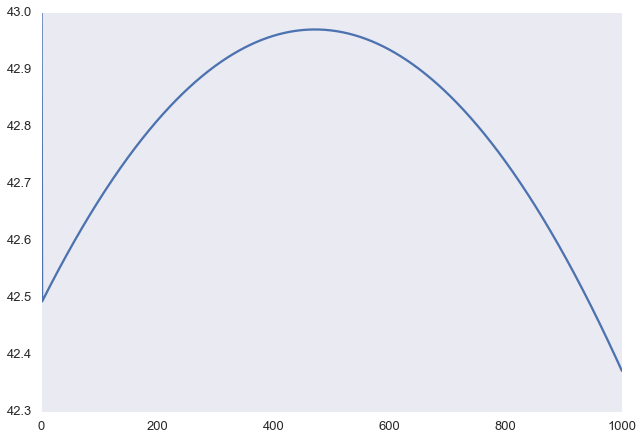

In [37]:
plt.plot(body[:,-1,0])
# plt.plot(x_sensed[:,2])

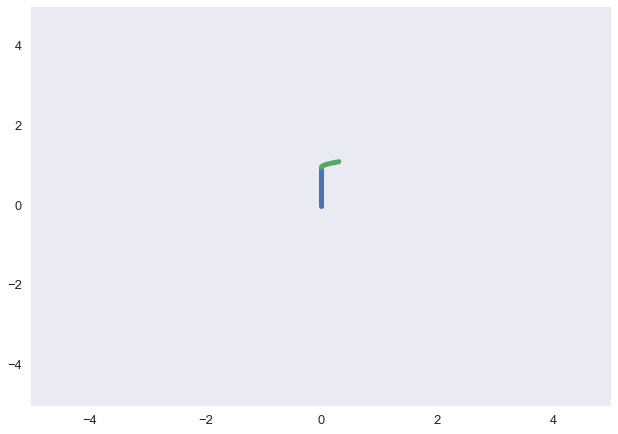

In [41]:
# based on http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 115), ylim=(-35, 15))
ax = plt.axes(xlim=(-5, 5), ylim=(-5, 5))


sheath, = ax.plot([], [], lw=5)
leader, = ax.plot([], [], lw=5)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
frame_number = 300
start_offset = 0
data_length  = len(time_array) - start_offset
resolution   = int(np.floor(data_length / frame_number)) - 5 #for some reason need fudge factor

def nextframe(i):
    i = i*resolution + start_offset
    num_points = 10
    sheath.set_data(body[i, :num_points,2], -body[i, :num_points,1])
    leader.set_data(body[i, num_points:,2], -body[i, num_points:,1])
    line.set_data(y[i], -z[i])
#     print(y[i],-z[i])
    return sheath, leader, line

# call the animator.  blit=True means only re-draw the parts that have changed.
save_time = time.perf_counter()
anim = animation.FuncAnimation(fig, nextframe, init_func=init,
                               frames=frame_number, interval=20, blit=True)

anim.save('robot_motion.mp4', writer = animation.FFMpegWriter(fps = 20))

video = io.open('robot_motion.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
# print(time.perf_counter() - save_time)

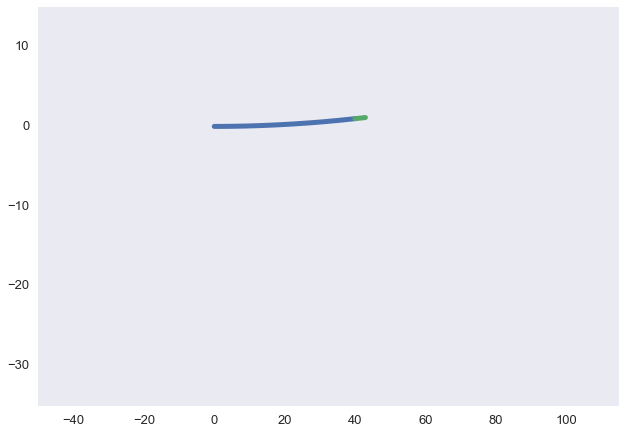

In [39]:
# based on http://jakevdp.github.io/blog/2013/05/12/embedding-matplotlib-animations/
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-50, 115), ylim=(-35, 15))
# ax = plt.axes(xlim=(-20, 20), ylim=(-35, 15))


sheath, = ax.plot([], [], lw=5)
leader, = ax.plot([], [], lw=5)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
frame_number = 300
start_offset = 0
data_length  = len(time_array) - start_offset
resolution   = int(np.floor(data_length / frame_number)) - 5 #for some reason need fudge factor

def nextframe(i):
    i = i*resolution + start_offset
    num_points = 10
    sheath.set_data(body[i, :num_points,0], -body[i, :num_points,1])
    leader.set_data(body[i, num_points:,0], -body[i, num_points:,1])
    line.set_data(y[i], -z[i])
#     print(y[i],-z[i])
    return sheath, leader, line

# call the animator.  blit=True means only re-draw the parts that have changed.
save_time = time.perf_counter()
anim = animation.FuncAnimation(fig, nextframe, init_func=init,
                               frames=frame_number, interval=20, blit=True)

anim.save('robot_motion.mp4', writer = animation.FFMpegWriter(fps = 20))

video = io.open('robot_motion.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))
# print(time.perf_counter() - save_time)

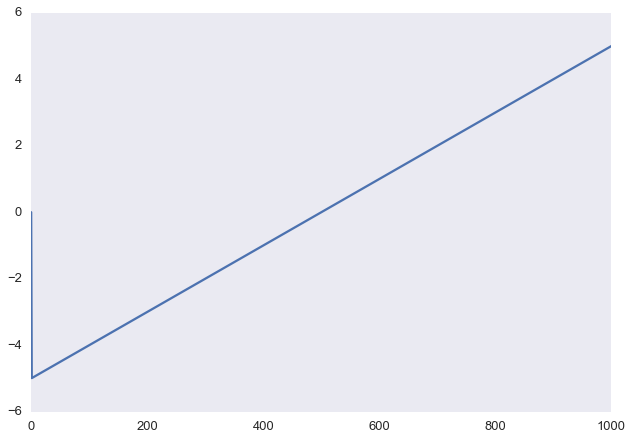

In [15]:
plt.plot(q[:,1])

In [ ]:
video = io.open('robot_motion.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))


In [ ]:
plt.plot(J[:,:,4])

In [ ]:
J[0,:,:]

In [ ]:
from matplotlib import animation, pyplot as plt
from tempfile import NamedTemporaryFile

VIDEO_TAG = """<video controls autoplay>
 <source src="data:{0}
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.m4v') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim.to_html5_video()
    # prevent figure displayed as a PNG below the animation
    plt.close()
    
    return VIDEO_TAG.format(anim.to_html5_video())

animation.Animation._repr_html_ = anim_to_html

In [ ]:
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(0, 45), ylim=(-15, 15))
sheath, = ax.plot([], [], lw=2)
leader, = ax.plot([], [], lw=2)
line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.

animation.FuncAnimation(fig, nextframe, init_func=init,
                               frames=300, interval=20, blit=True)

In [ ]:
xd = np.zeros(1000)
for i in range(1000):
    body = robot.GetPointsAlongBody(q[i], num = 2, with_sheath = True)
    xd[i] = z[i] - body[-1, 2]
plt.plot(xd)

In [ ]:
plt.plot(q[:,-2])

In [ ]:
plt.plot(y,z)